In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# %matplotlib widget

# Gridsearch

In [2]:
df_paper_vs_gridsearch = pd.read_csv("results_csv_files/paper_vs_gridsearch.csv")
df_paper_vs_gridsearch["Name"] = df_paper_vs_gridsearch["Name"].str.extract(r"^naive-parallel_(?P<name>.*)_temp")["name"]
df_paper_vs_gridsearch['val_num_valid_mols'] = df_paper_vs_gridsearch['val_num_valid_mols'].apply(lambda x: x / 10)
df_paper_vs_gridsearch

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,accelerator,alpha,...,val_loss,val_num_non_empty_preds,val_num_novel_mols,val_num_valid_mols,val_top_10_accuracy,val_top_10_max_tanimoto_sim,val_top_10_mces_dist,val_top_1_accuracy,val_top_1_max_tanimoto_sim,val_top_1_mces_dist
0,smiles_transformer_paper,failed,-,NaN,NaN,2025-04-19T16:27:37.000Z,11343,NaN,gpu,1,...,0.313738,10.0,5.673169,0.758217,0,0.178263,21.928457,0,0.087609,47.770214
1,smiles_low_val_loss,failed,-,NaN,NaN,2025-02-28T16:56:50.000Z,15780,NaN,gpu,1,...,0.303417,NaN,NaN,0.648587,0,0.167424,22.525091,0,0.071197,54.498352


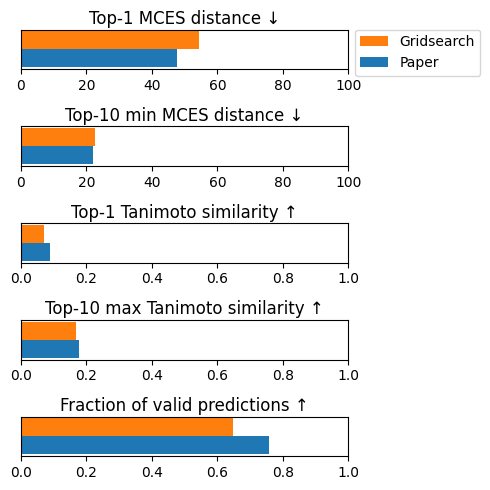

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Map internal model names to display names
name_map = {
    "smiles_transformer_paper": "Paper",
    "smiles_low_val_loss":    "Gridsearch"
}
df = df_paper_vs_gridsearch.copy()
df["Model"] = df["Name"].map(name_map)

# 2. List all the columns that are your metrics
metric_cols = ["val_top_1_mces_dist", "val_top_10_mces_dist", "val_top_1_max_tanimoto_sim", "val_top_10_max_tanimoto_sim", "val_num_valid_mols"]
ranges = [100, 100, 1, 1, 1]

metric_name_map = {
    "val_top_1_mces_dist": "Top-1 MCES distance ↓",
    "val_top_10_mces_dist": "Top-10 min MCES distance ↓",
    "val_top_1_max_tanimoto_sim": "Top-1 Tanimoto similarity ↑",
    "val_top_10_max_tanimoto_sim": "Top-10 max Tanimoto similarity ↑",
    "val_num_valid_mols": "Fraction of valid predictions ↑"
}

# 3. Make one subplot per metric
models = ["Paper", "Gridsearch"]
n_metrics = len(metric_cols)
fig, axes = plt.subplots(
    nrows=n_metrics,
    ncols=1,
    figsize=(5, n_metrics * 1.0),
    sharex=False
)

# 4. Plot two bars per subplot, hide y‑ticks, add legend once
for ax, metric, r in zip(axes, metric_cols, ranges):
    # grab the two values
    vals = [df.loc[df["Model"] == m, metric].values[0] for m in models]
    y_pos = np.arange(len(models))  # [0, 1]
    bar_height = 1

    for i, (m, v) in enumerate(zip(models, vals)):
        # only add labels on the first axis, so legend only appears once
        label = m if ax is axes[0] else None
        ax.barh(y_pos[i], v, height=bar_height, label=label)

    # 5. Tidy up each subplot
    ax.set_yticks([])  # no repeated model names
    # use the metric name as the xlabel (auto‑scaled)
    #ax.set_xlabel(metric.replace("val_", "").replace("_", " ").title())
    ax.set_xlim(0, r)
    # optionally, give the subplot a title too:
    ax.set_title(metric_name_map[metric], pad=4)

# 5. Shrink left plots to make room for the legend on the right
fig.subplots_adjust(right=0.75)

# pull out the handles & labels
handles, labels = axes[0].get_legend_handles_labels()

# reverse them so the top bar appears first in the legend
axes[0].legend(
    handles[::-1],
    labels[::-1],
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)

fig.tight_layout(h_pad=1.0)
plt.show()


# Samplers Load Data

In [4]:
# Load the CSV file into a DataFrame
df_q_incl = pd.read_csv("results_csv_files/top-q_samplers_last_token_included.csv")
df_q_incl = pd.concat([df_q_incl, pd.read_csv("results_csv_files/top-q_samplers_last_token_included_cont.csv")], ignore_index=True)

# Extract the temperature value.
# The regex looks for the substring 'temp' followed by a number in scientific notation (e.g., 90e-2)
df_q_incl["temp"] = df_q_incl["Name"].str.extract(r"temp(?P<temp>\d+e-?\d+)")["temp"].astype(float)

# Extract the q value.
# The regex looks for the substring '_q' followed by a number in scientific notation (e.g., 99e-2)
df_q_incl["q"] = df_q_incl["Name"].str.extract(r"_q(?P<q>\d+e-?\d+)")["q"].astype(float)

df_q_incl["Name"] = df_q_incl["Name"].str.extract(r"^(?P<name>.*)_temp")["name"]
df_q_incl['val_num_valid_mols'] = df_q_incl['val_num_valid_mols'].apply(lambda x: x / 10)

cols = ['Name','q','temp','Runtime','val_top_1_mces_dist','val_top_10_mces_dist','val_top_1_max_tanimoto_sim','val_top_10_max_tanimoto_sim','val_num_valid_mols','val_top_1_accuracy','val_top_10_accuracy']
df_q_incl = df_q_incl[cols]
df_q_incl.head()

,Name,q,temp,Runtime,val_top_1_mces_dist,val_top_10_mces_dist,val_top_1_max_tanimoto_sim,val_top_10_max_tanimoto_sim,val_num_valid_mols,val_top_1_accuracy,val_top_10_accuracy
0,top-q-parallel_smiles_lowest_val_loss,0.90,0.8,22395,44.448814,21.786428,0.091619,0.178289,0.788342,0,0
1,top-q-parallel_smiles_lowest_val_loss,0.90,0.7,25984,40.578465,21.484739,0.100056,0.185396,0.838520,0,0
2,top-q-parallel_smiles_lowest_val_loss,0.70,0.7,26152,34.258095,21.723995,0.113852,0.179304,0.915564,0,0
3,top-q-parallel_smiles_lowest_val_loss,0.80,0.7,33452,36.130142,21.630989,0.109113,0.182343,0.893716,0,0
4,top-q-parallel_smiles_lowest_val_loss,0.95,0.8,13654,53.722889,22.845566,0.072100,0.163502,0.665423,0,0


In [5]:
# Load the CSV file into a DataFrame
df_k = pd.read_csv("results_csv_files/top-k_samplers.csv")
df_k = pd.concat([df_k, pd.read_csv("results_csv_files/top-k_samplers_cont.csv")], ignore_index=True)

# Extract the temperature value.
# The regex looks for the substring 'temp' followed by a number in scientific notation (e.g., 90e-2)
df_k["temp"] = df_k["Name"].str.extract(r"temp(?P<temp>\d+e-?\d+)")["temp"].astype(float)

# Extract the q value.
# The regex looks for the substring '_q' followed by a number in scientific notation (e.g., 99e-2)
df_k["k"] = df_k["Name"].str.extract(r"_k(?P<k>\d+)")["k"].astype(float)

df_k["Name"] = df_k["Name"].str.extract(r"^(?P<name>.*)_temp")["name"]
df_k['val_num_valid_mols'] = df_k['val_num_valid_mols'].apply(lambda x: x / 10)

cols = ['Name', 'k', 'temp','Runtime','val_top_1_mces_dist','val_top_10_mces_dist','val_top_1_max_tanimoto_sim','val_top_10_max_tanimoto_sim','val_num_valid_mols','val_top_1_accuracy','val_top_10_accuracy']
df_k = df_k[cols]

df_k.head()

,Name,k,temp,Runtime,val_top_1_mces_dist,val_top_10_mces_dist,val_top_1_max_tanimoto_sim,val_top_10_max_tanimoto_sim,val_num_valid_mols,val_top_1_accuracy,val_top_10_accuracy
0,SMILES_LOW_VAL_LOSS_top-k,50.0,1.5,3838,79.956841,32.931416,0.026862,0.107403,0.297632,0,0
1,SMILES_LOW_VAL_LOSS_top-k,20.0,1.5,4274,78.592644,31.899017,0.029108,0.111588,0.316161,0,0
2,SMILES_LOW_VAL_LOSS_top-k,10.0,1.5,4860,77.010735,31.421766,0.032069,0.117171,0.335509,0,0
3,SMILES_LOW_VAL_LOSS_top-k,5.0,1.5,6835,72.657623,29.824129,0.039362,0.128935,0.391266,0,0
4,SMILES_LOW_VAL_LOSS_top-k,3.0,1.5,10870,64.779274,26.146765,0.053155,0.147263,0.497741,0,0


In [6]:
# Load the CSV file into a DataFrame
df_naive = pd.read_csv("results_csv_files/naive-parallel_samplers.csv")

# Extract the temperature value.
# The regex looks for the substring 'temp' followed by a number in scientific notation (e.g., 90e-2)
df_naive["temp"] = df_naive["Name"].str.extract(r"temp(?P<temp>\d+e-?\d+)")["temp"].astype(float)
cols = ['Name','temp','Runtime','val_top_1_mces_dist','val_top_10_mces_dist','val_top_1_max_tanimoto_sim','val_top_10_max_tanimoto_sim','val_num_valid_mols','val_top_1_accuracy','val_top_10_accuracy']
df_naive = df_naive[cols]

df_naive["Name"] = df_naive["Name"].str.extract(r"^(?P<name>.*)_temp")["name"]
df_naive['val_num_valid_mols'] = df_naive['val_num_valid_mols'].apply(lambda x: x / 10)

df_naive.head()

,Name,temp,Runtime,val_top_1_mces_dist,val_top_10_mces_dist,val_top_1_max_tanimoto_sim,val_top_10_max_tanimoto_sim,val_num_valid_mols,val_top_1_accuracy,val_top_10_accuracy
0,SMILES_LOW_VAL_LOSS_naive-parallel,0.4,25616,35.400124,21.555304,0.111673,0.180824,0.900175,0,0
1,SMILES_LOW_VAL_LOSS_naive-parallel,0.3,21955,33.564697,21.786633,0.116209,0.177075,0.918580,0,0
2,SMILES_LOW_VAL_LOSS_naive-parallel,0.2,14889,32.191288,22.134386,0.119392,0.169986,0.935169,0,0
3,SMILES_LOW_VAL_LOSS_naive-parallel,0.1,7501,30.155516,23.062021,0.124073,0.159245,0.956791,0,0
4,SMILES_LOW_VAL_LOSS_naive-parallel,1.5,3897,78.924240,33.217251,0.027553,0.104664,0.313691,0,0


In [7]:
# Load the CSV file into a DataFrame
df_beamsearch = pd.read_csv("results_csv_files/beamsearch_samplers.csv")

df_beamsearch["bw"] = df_beamsearch["Name"].str.extract(r"bw(?P<bw>\d+)")["bw"].astype(int)
df_beamsearch["alpha"] = df_beamsearch["Name"].str.extract(r"alph(?P<alph>\d+e-?\d+)")["alph"].astype(float)

df_beamsearch["Name"] = df_beamsearch["Name"].str.extract(r"^(?P<name>.*)_bw")["name"]
df_beamsearch['val_num_valid_mols'] = df_beamsearch['val_num_valid_mols'].apply(lambda x: x / 10 if x > 1 else x)

cols = ['Name','bw','alpha','Runtime','val_top_1_mces_dist','val_top_10_mces_dist','val_top_1_max_tanimoto_sim','val_top_10_max_tanimoto_sim','val_num_valid_mols','val_top_1_accuracy','val_top_10_accuracy']
df_beamsearch = df_beamsearch[cols]
df_beamsearch.head()

,Name,bw,alpha,Runtime,val_top_1_mces_dist,val_top_10_mces_dist,val_top_1_max_tanimoto_sim,val_top_10_max_tanimoto_sim,val_num_valid_mols,val_top_1_accuracy,val_top_10_accuracy
0,beam-search_smiles_lowest_val_loss,200,1.0,17077,29.087576,23.796387,0.114305,0.155756,0.988738,0,0
1,beam-search_smiles_lowest_val_loss,200,2.0,17083,29.087576,23.796387,0.114305,0.155756,0.988738,0,0
2,beam-search_smiles_lowest_val_loss,200,0.1,17144,29.087576,23.796387,0.114305,0.155756,0.988738,0,0
3,beam-search_smiles_lowest_val_loss,100,1.0,10500,29.078852,23.853827,0.114367,0.156316,0.986685,0,0
4,beam-search_smiles_lowest_val_loss,100,2.0,10523,29.078852,23.853827,0.114367,0.156316,0.986685,0,0


In [8]:
def make_3d_plot(df, x_val, y_val, z_val, close_all_plots=True, z_plane=None):
    if close_all_plots:
        plt.close('all')
    
    # Extract the scattered data coordinates
    x = df[x_val].values         # x-axis: Temperature
    y = df[y_val].values            # y-axis: q
    z = df[z_val].values  # z-axis: Value (height)
    
    # Create a regular grid to interpolate the scattered data.
    # Adjust the number of grid points (here 50x50) as needed.
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate the z values (q) onto the grid based on x and y.
    # You can try different methods ('linear', 'cubic', or 'nearest')
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface. The alpha value makes the surface a bit transparent.
    surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.8)
    
    # Optionally, scatter the original data points to see where they lie
    ax.scatter(x, y, z, color='r', s=50, label='Data Points')

    if z_plane is not None:
        plane = ax.plot_surface(xi, yi, np.full(xi.shape, z_plane), color='gray', alpha=0.8, label='Plane at z=0.5')
    
    # Set axis labels and title
    ax.set_xlabel(x_val)
    ax.set_ylabel(y_val)
    ax.set_zlabel(z_val)
    plt.title(f"{x_val} VS {y_val} VS {z_val}")
    
    # Add a colorbar for the surface
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    return ax
    

# Top-k

In [ ]:
make_3d_plot(df_k, "temp", "k", "val_top_1_mces_dist", z_plane=28.712080001831055)

In [ ]:
make_3d_plot(df_k, "temp", "k", "val_top_10_mces_dist", z_plane=28.712080001831055)

In [ ]:
make_3d_plot(df_k, "temp", "k", "Runtime")

# Top-q

In [ ]:
make_3d_plot(df_q, "temp", "q", "val_top_1_mces_dist", z_plane=28.712080001831055)

In [ ]:
make_3d_plot(df_q, "temp", "q", "Runtime")

# Beam Search / Greedy (compared to Top-q)

In [ ]:
make_3d_plot(df_q, "temp", "q", "val_top_1_mces_dist", z_plane=28.712080001831055)

In [ ]:
make_3d_plot(df_q, "temp", "q", "val_top_10_mces_dist", z_plane=28.712080001831055)

In [ ]:
df_q[df_q["val_top_10_mces_dist"] == min(df_q["val_top_10_mces_dist"])][["Name", "val_top_10_mces_dist"]]

In [ ]:
df_k[df_k["val_top_10_mces_dist"] == min(df_k["val_top_10_mces_dist"])][["Name", "val_top_10_mces_dist"]]

In [ ]:
df_naive[df_naive["val_top_10_mces_dist"] == min(df_naive["val_top_10_mces_dist"])][["Name", "val_top_10_mces_dist"]]

# 2D plots

## Naive

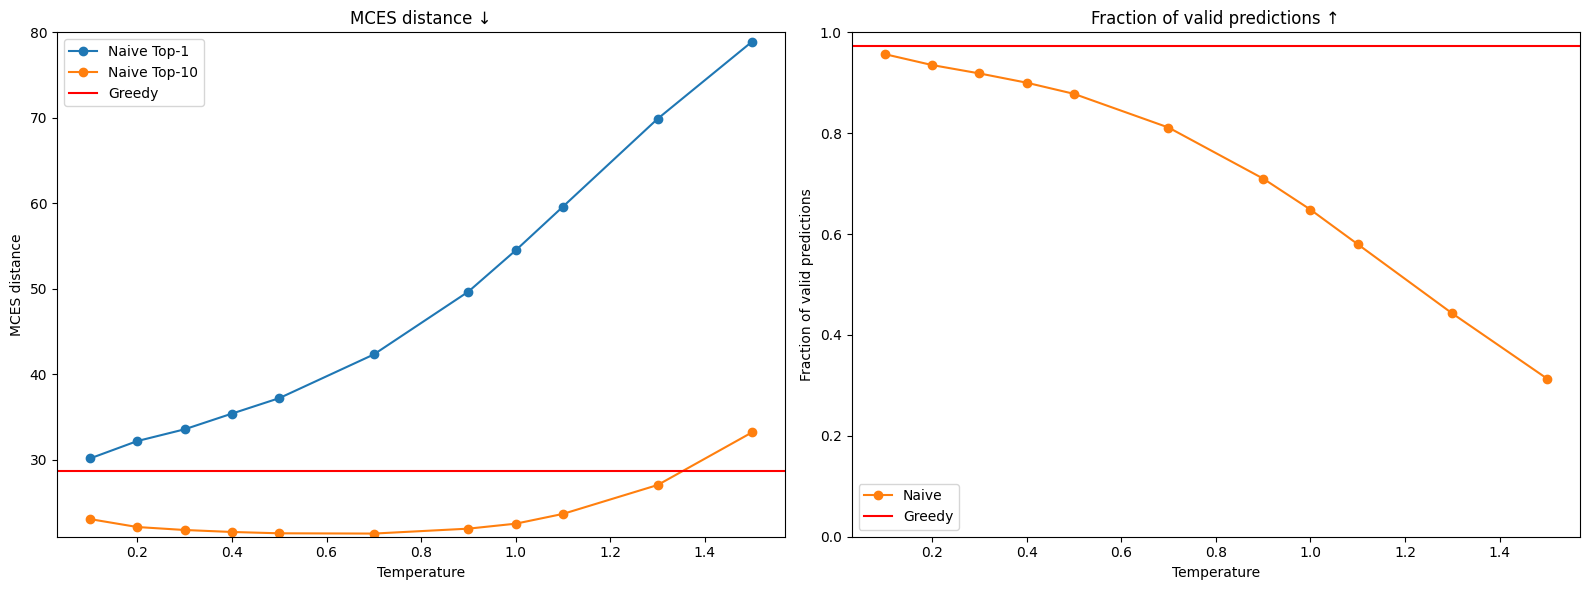

In [9]:
x = 'temp'
y_0 = 'val_top_1_mces_dist', 'val_top_10_mces_dist'
y_1 = 'val_num_valid_mols'
df = df_naive

data = df.sort_values(x)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(data[x], data[y_0[0]], 'o-', label= f"Naive Top-1")
axes[0].plot(data[x], data[y_0[1]], 'o-', label=f"Naive Top-10")
axes[0].axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")
    
axes[0].set_ylim(21, 80)
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel("MCES distance")
axes[0].set_title("MCES distance ↓")
axes[0].legend()

axes[1].plot([], 'o-')
axes[1].plot(data[x], data[y_1], 'o-', label= f"Naive")
axes[1].axhline(y = 0.97303003, color = 'r', linestyle = '-', label="Greedy")
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("Fraction of valid predictions")
axes[1].set_title("Fraction of valid predictions ↑")
axes[1].legend()


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Top-k

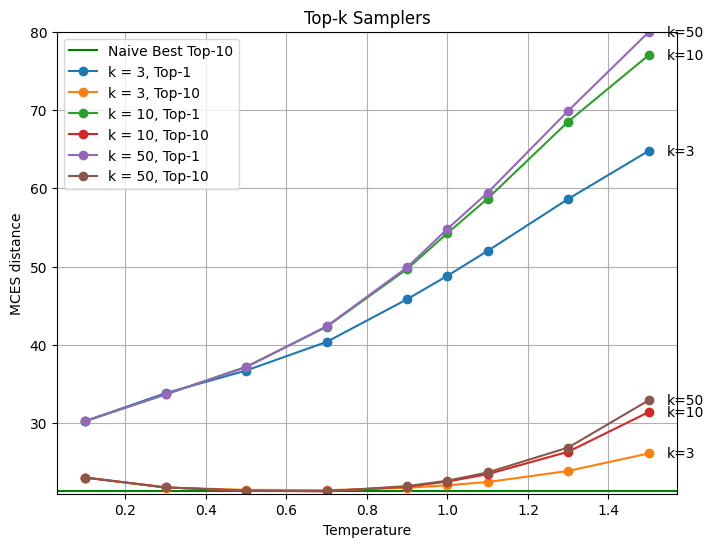

In [10]:
x = 'temp'
y = 'val_top_1_mces_dist'
y_2 = 'val_top_10_mces_dist'

plt.figure(figsize=(8, 6))
#plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")
plt.axhline(y = 21.368315, color = 'g', linestyle = '-', label="Naive Best Top-10")

for k in [3, 10, 50]:
    data = df_k[df_k["k"] == k].sort_values(x)
    plt.plot(data[x], data[y], 'o-', label=f"k = {str(k)}, Top-1")
    plt.text(data[x].to_list()[-1] + 0.045, data[y].to_list()[-1], f"k={str(k)}", fontsize=10, verticalalignment='center')
    plt.plot(data[x], data[y_2], 'o-', label=f"k = {str(k)}, Top-10")
    plt.text(data[x].to_list()[-1] + 0.045, data[y_2].to_list()[-1], f"k={str(k)}", fontsize=10, verticalalignment='center')
 
plt.ylim(21, 80)
plt.xlabel("Temperature")
plt.ylabel("MCES distance")
plt.title("Top-k Samplers")
plt.legend()
plt.grid(True)
plt.show()

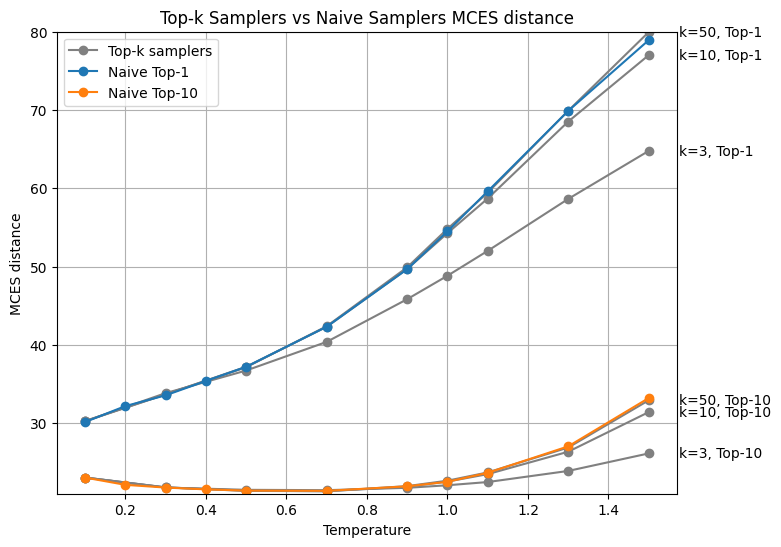

In [11]:
x = 'temp'
y = 'val_top_1_mces_dist'
y_2 = 'val_top_10_mces_dist'

plt.figure(figsize=(8, 6))
#plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")

for k in [3, 10, 50]:
    data = df_k[df_k["k"] == k].sort_values(x)
    plt.plot(data[x], data[y], 'o-',color='gray', label='Top-k samplers' if k == 3 else None)
    plt.text(data[x].to_list()[-1] + 0.075, data[y].to_list()[-1], f"k={str(k)}, Top-1", fontsize=10, verticalalignment='center')
    plt.plot(data[x], data[y_2], 'o-',color='gray')
    plt.text(data[x].to_list()[-1] + 0.075, data[y_2].to_list()[-1], f"k={str(k)}, Top-10", fontsize=10, verticalalignment='center')

df = df_naive
data = df.sort_values(x)
plt.plot(data[x], data[y], 'o-', label= f"Naive Top-1")
plt.plot(data[x], data[y_2], 'o-', label=f"Naive Top-10")
 
plt.ylim(21, 80)
plt.xlabel("Temperature")
plt.ylabel("MCES distance")
plt.title("Top-k Samplers vs Naive Samplers MCES distance")
plt.legend()
plt.grid(True)
plt.show()

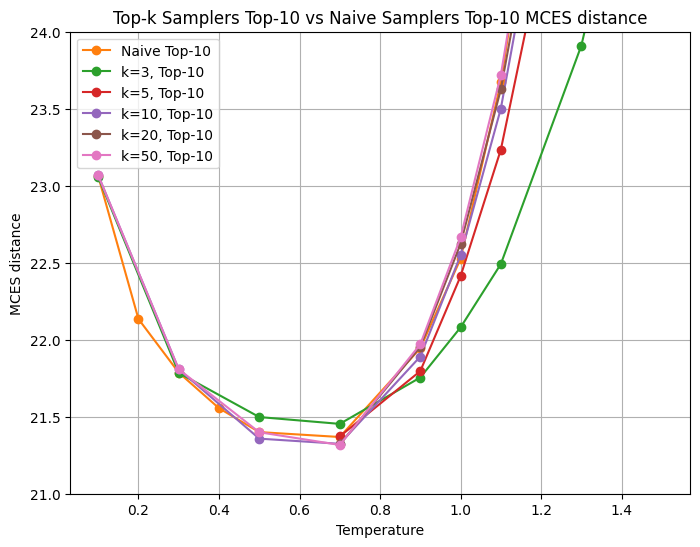

In [12]:
x = 'temp'
y = 'val_top_10_mces_dist'

plt.figure(figsize=(8, 6))
#plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")

df = df_naive
data = df.sort_values(x)
plt.plot([], 'o-')
plt.plot(data[x], data[y], 'o-', label=f"Naive Top-10")

for k in [3, 5, 10, 20, 50]:
    data = df_k[df_k["k"] == k].sort_values(x)
    plt.plot(data[x], data[y], 'o-', label= f"k={str(k)}, Top-10")

plt.ylim(21, 24)
plt.xlabel("Temperature")
plt.ylabel("MCES distance")
plt.title("Top-k Samplers Top-10 vs Naive Samplers Top-10 MCES distance")
plt.legend()
plt.grid(True)
plt.show()

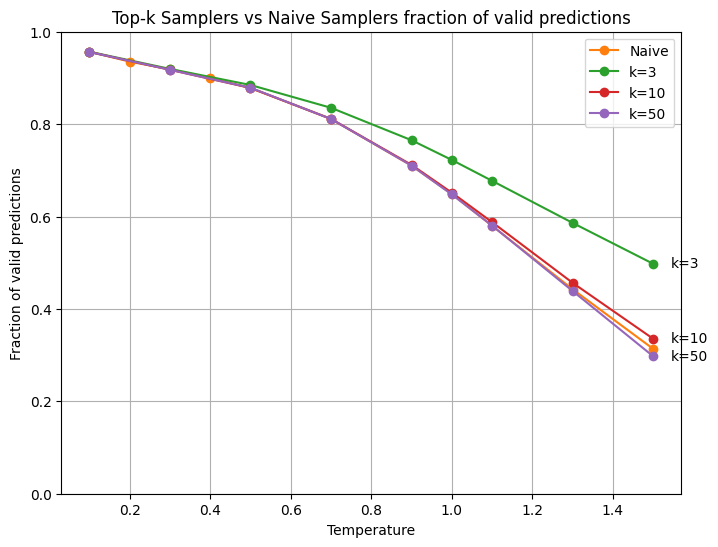

In [13]:
x = 'temp'
y = 'val_num_valid_mols'

plt.figure(figsize=(8, 6))
#plt.axhline(y = 0.97303003, color = 'r', linestyle = '-', label="Greedy")

df = df_naive
data = df.sort_values(x)
plt.plot([], 'o-')
plt.plot(data[x], data[y], 'o-', label= f"Naive")

for k in [3, 10, 50]:
    data = df_k[df_k["k"] == k].sort_values(x)
    plt.plot(data[x], data[y], 'o-', label= f"k={str(k)}")
    plt.text(data[x].to_list()[-1] + 0.045, (data[y]).to_list()[-1], f"k={str(k)}", fontsize=10, verticalalignment='center')
 
plt.ylim(0, 1)
plt.xlabel("Temperature")
plt.ylabel("Fraction of valid predictions")
plt.title("Top-k Samplers vs Naive Samplers fraction of valid predictions")
plt.legend()
plt.grid(True)
plt.show()

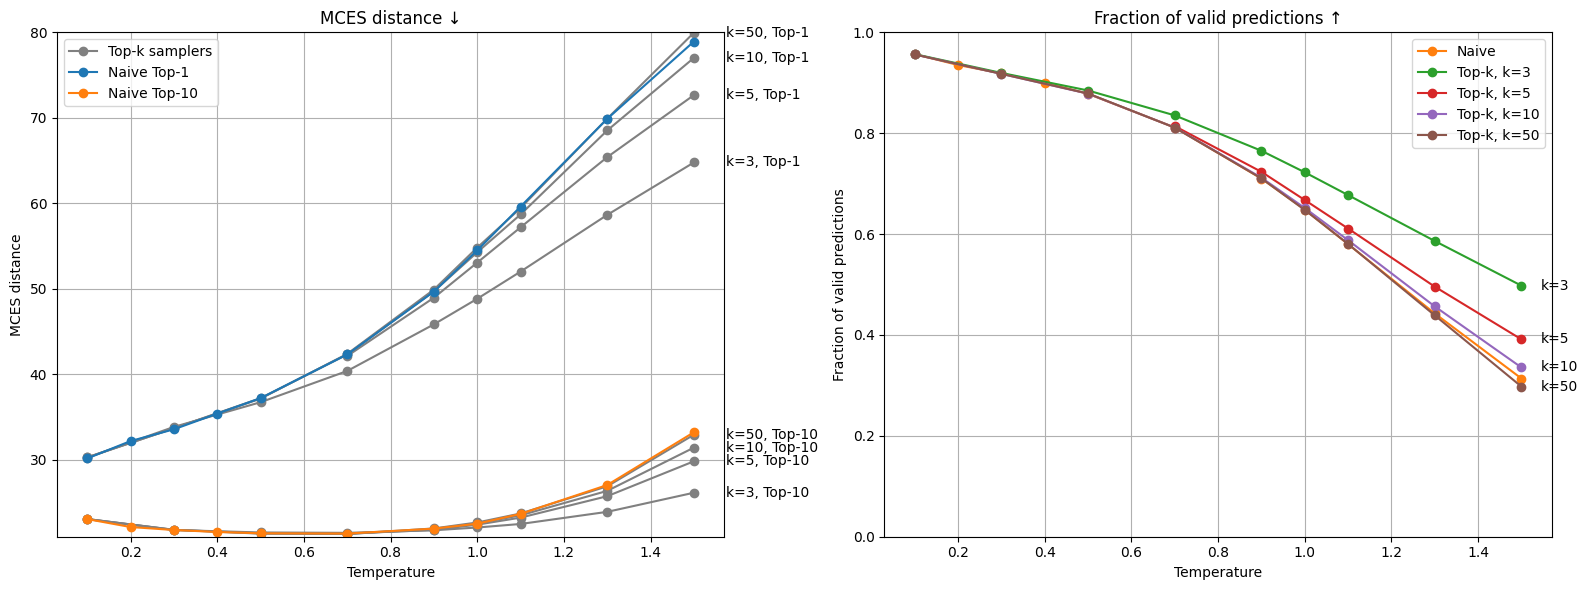

In [14]:
x = 'temp'
y_0 = 'val_top_1_mces_dist', 'val_top_10_mces_dist'
y_1 = 'val_num_valid_mols'

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")

for k in [3, 5, 10, 50]:
    data = df_k[df_k["k"] == k].sort_values(x)
    axes[0].plot(data[x], data[y_0[0]], 'o-',color='gray', label='Top-k samplers' if k == 3 else None)
    axes[0].text(data[x].to_list()[-1] + 0.075, data[y_0[0]].to_list()[-1], f"k={str(k)}, Top-1", fontsize=10, verticalalignment='center')
    axes[0].plot(data[x], data[y_0[1]], 'o-',color='gray')
    axes[0].text(data[x].to_list()[-1] + 0.075, data[y_0[1]].to_list()[-1], f"k={str(k)}, Top-10", fontsize=10, verticalalignment='center')

df = df_naive
data = df.sort_values(x)
axes[0].plot(data[x], data[y_0[0]], 'o-', label= f"Naive Top-1")
axes[0].plot(data[x], data[y_0[1]], 'o-', label=f"Naive Top-10")
 
axes[0].set_ylim(21, 80)
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("MCES distance")
axes[0].set_title("MCES distance ↓")
axes[0].legend()
axes[0].grid(True)

axes[1].plot([], 'o-')
axes[1].plot(data[x], data[y_1], 'o-', label= f"Naive")

for k in [3, 5, 10, 50]:
    data = df_k[df_k["k"] == k].sort_values(x)
    axes[1].plot(data[x], data[y_1], 'o-', label= f"Top-k, k={str(k)}")
    axes[1].text(data[x].to_list()[-1] + 0.045, (data[y_1]).to_list()[-1], f"k={str(k)}", fontsize=10, verticalalignment='center')
 
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("Fraction of valid predictions")
axes[1].set_title("Fraction of valid predictions ↑")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
best_naive['val_top_10_mces_dist'].to_list()

NameError: name 'best_naive' is not defined

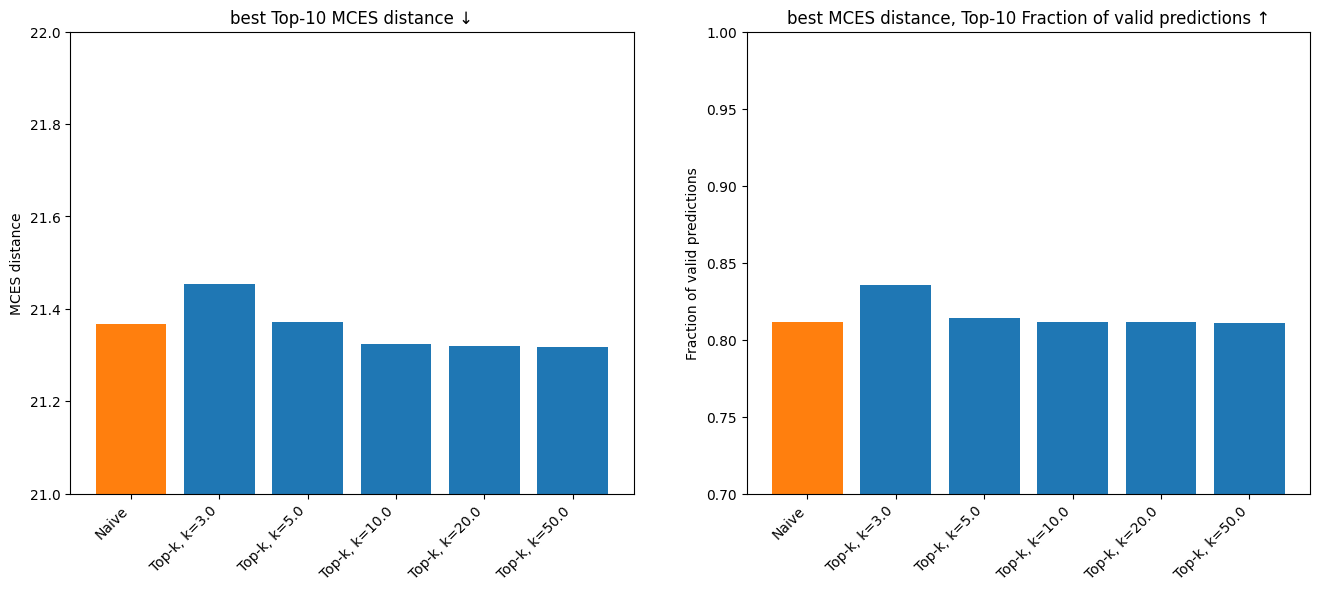

In [16]:
idx = df_k.groupby('k')['val_top_10_mces_dist'].idxmin()
best_topk = df_k.loc[idx].reset_index(drop=True)

idx = df_naive['val_top_10_mces_dist'].idxmin()
best_naive = df_naive[df_naive["temp"] == df_naive.loc[idx].iloc[1]]

k = best_topk.k.to_list()

values = best_naive['val_top_10_mces_dist'].to_list() + best_topk['val_top_10_mces_dist'].to_list()
names = ["Naive"] + [f"Top-k, k={_k}" for _k in k]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [default_colors[1]] + ([default_colors[0]] * len(k))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].bar(names, values, color=colors)
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right')
axes[0].set_ylabel("MCES distance")
axes[0].set_title("best Top-10 MCES distance ↓")
axes[0].set_ylim(21, 22)

values = best_naive['val_num_valid_mols'].to_list() + best_topk['val_num_valid_mols'].to_list()
axes[1].bar(names, values, color=colors)
axes[1].set_xticks(range(len(names)))
axes[1].set_xticklabels(names, rotation=45, ha='right')
axes[1].set_ylabel("Fraction of valid predictions")
axes[1].set_title("best MCES distance, Top-10 Fraction of valid predictions ↑")
axes[1].set_ylim(.7, 1)

plt.show()

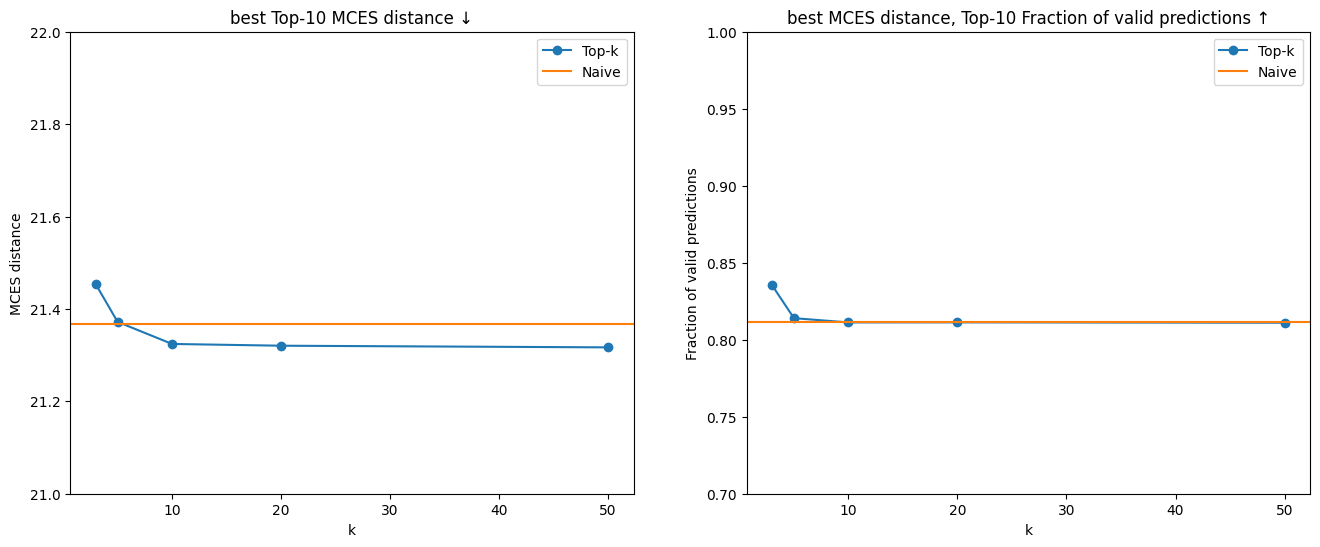

In [17]:
idx = df_k.groupby('k')['val_top_10_mces_dist'].idxmin()
best_topk = df_k.loc[idx].reset_index(drop=True)

idx = df_naive['val_top_10_mces_dist'].idxmin()
best_naive = df_naive[df_naive["temp"] == df_naive.loc[idx].iloc[1]]

k = best_topk.k.to_list()

values = best_topk['val_top_10_mces_dist'].to_list()
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [default_colors[1]] + ([default_colors[0]] * len(k))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(k, values, 'o-', label="Top-k")
axes[0].axhline(y = best_naive['val_top_10_mces_dist'].to_list()[0], linestyle = '-', label="Naive", c=default_colors[1])
axes[0].set_xlabel("k")
axes[0].set_ylabel("MCES distance")
axes[0].set_title("best Top-10 MCES distance ↓")
axes[0].set_ylim(21, 22)
axes[0].legend()

values = best_topk['val_num_valid_mols'].to_list()
axes[1].plot(k, values, 'o-', label="Top-k")
axes[1].axhline(y = best_naive['val_num_valid_mols'].to_list()[0], linestyle = '-', label="Naive", c=default_colors[1])
axes[1].set_xlabel("k")
axes[1].set_ylabel("Fraction of valid predictions")
axes[1].set_title("best MCES distance, Top-10 Fraction of valid predictions ↑")
axes[1].set_ylim(.7, 1)
axes[1].legend()

plt.show()

## Top-q

In [ ]:
x = 'temp'
y = 'val_top_1_mces_dist'
y_2 = 'val_top_10_mces_dist'

plt.figure(figsize=(8, 6))
plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")

df = df_naive
data = df.sort_values(x)
plt.plot(data[x], data[y], 'o-', label= f"naive_{y}")
plt.plot(data[x], data[y_2], 'o-', label=f"naive_{y_2}")

for q in np.unique(df_q_incl.q):
    data = df_q_incl[df_q_incl["q"] == q].sort_values(x)
    plt.plot(data[x], data[y], 'o-', color="gray", label= f"top_q_samplers" if q==np.unique(df_q_incl.q)[0] else None)
    plt.text(data[x].to_list()[-1] + 0.025, data[y].to_list()[-1], f"q={str(q)}", fontsize=10, verticalalignment='center')
    plt.plot(data[x], data[y_2], 'o-', color="gray")
    plt.text(data[x].to_list()[-1] + 0.025, data[y_2].to_list()[-1], f"q={str(q)}", fontsize=10, verticalalignment='center')
 
plt.ylim(21, 80)
plt.xlabel(x)
plt.ylabel("mces_dist")
plt.title("Top-q Samplers")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x = 'temp'
y = 'val_top_10_mces_dist'
y_2 = 'val_top_1_mces_dist'

plt.figure(figsize=(8, 6))

df = df_naive
data = df.sort_values(x)
plt.plot(data[x], data[y_2], 'o-')
plt.plot(data[x], data[y], 'o-', label= f"Naive Top-10")


for q in np.unique(df_q_incl.q):
    data = df_q_incl[df_q_incl["q"] == q].sort_values(x)
    plt.plot(data[x], data[y], 'o-', label= f"p = {str(q)}, Top-10")
    #plt.text(data[x].to_list()[-1] + 0.025, data[y].to_list()[-1], f"q={str(q)}", fontsize=10, verticalalignment='center')
 
plt.ylim(21, 24)
plt.xlabel("Temperature")
plt.ylabel("MCES distance")
plt.title("Top-p Samplers Top-10 vs Naive Samplers Top-10 MCES distance")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x = 'temp'
y_0 = 'val_top_1_mces_dist', 'val_top_10_mces_dist'
y_1 = 'val_num_valid_mols'

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")

for q in [.6, .7, .8, .9, .95]:
    data = df_q_incl[df_q_incl["q"] == q].sort_values(x)
    axes[0].plot(data[x], data[y_0[0]], 'o-',color='gray', label='Top-p samplers' if q == .6 else None)
    axes[0].text(data[x].to_list()[-1] + 0.075, data[y_0[0]].to_list()[-1], f"p={str(q)}, Top-1", fontsize=10, verticalalignment='center')
    axes[0].plot(data[x], data[y_0[1]], 'o-',color='gray')
    axes[0].text(data[x].to_list()[-1] + 0.075, data[y_0[1]].to_list()[-1], f"p={str(q)}, Top-10", fontsize=10, verticalalignment='center')

df = df_naive
data = df.sort_values(x)
axes[0].plot(data[x], data[y_0[0]], 'o-', label= f"Naive Top-1")
axes[0].plot(data[x], data[y_0[1]], 'o-', label=f"Naive Top-10")
 
axes[0].set_ylim(21, 80)
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("MCES distance")
axes[0].set_title("MCES distance ↓")
axes[0].legend()
axes[0].grid(True)

axes[1].plot([], 'o-')
axes[1].plot(data[x], data[y_1], 'o-', label= f"Naive")

for q in [.6, .7, .8, .9, .95]:
    data = df_q_incl[df_q_incl["q"] == q].sort_values(x)
    axes[1].plot(data[x], data[y_1], 'o-', label= f"Top-p, p={str(q)}")
    axes[1].text(data[x].to_list()[-1] + 0.045, (data[y_1]).to_list()[-1], f"p={str(q)}", fontsize=10, verticalalignment='center')
 
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("Fraction of valid predictions")
axes[1].set_title("Fraction of valid predictions ↑")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
idx = df_q_incl.groupby('q')['val_top_10_mces_dist'].idxmin()
best_topk = df_q_incl.loc[idx].reset_index(drop=True)

idx = df_naive['val_top_10_mces_dist'].idxmin()
best_naive = df_naive[df_naive["temp"] == df_naive.loc[idx].iloc[1]]

k = best_topk.q.to_list()

values = best_naive['val_top_10_mces_dist'].to_list() + best_topk['val_top_10_mces_dist'].to_list()
names = ["Naive"] + [f"Top-p, p={_k}" for _k in k]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [default_colors[1]] + ([default_colors[0]] * len(k))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].bar(names, values, color=colors)
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right')
axes[0].set_ylabel("MCES distance")
axes[0].set_title("best Top-10 MCES distance ↓")
axes[0].set_ylim(21, 22)

values = best_naive['val_num_valid_mols'].to_list() + best_topk['val_num_valid_mols'].to_list()
axes[1].bar(names, values, color=colors)
axes[1].set_xticks(range(len(names)))
axes[1].set_xticklabels(names, rotation=45, ha='right')
axes[1].set_ylabel("Fraction of valid predictions")
axes[1].set_title("best MCES distance, Top-10 Fraction of valid predictions ↑")
axes[1].set_ylim(.7, 1)

plt.show()

## Beam-search

In [ ]:
x = 'bw'
y = 'val_top_1_mces_dist'
y_2 = 'val_top_10_mces_dist'

df = df_beamsearch
z = 'alpha'

plt.figure(figsize=(8, 6))
plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")
plt.axhline(y = 21.368315, color = 'g', linestyle = '-', label="Best_naive_top-10")


_z = 1.0
data = df[df[z] == _z].sort_values(x)
plt.plot(data[x], data[y], 'o-', label= f"beam-search_{y}")
plt.plot(data[x], data[y_2], 'o-', label=f"beam-search_{y_2}")
 
plt.ylim(21, 32)
plt.xlabel("Beam Width")
plt.ylabel("MCES Distance")
plt.title("Beam-search")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x = 'bw'
y = 'val_num_valid_mols'

df = df_beamsearch
z = 'alpha'

plt.figure(figsize=(8, 6))
#plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")
#plt.axhline(y = 21.368315, color = 'g', linestyle = '-', label="Best_naive_top-10")

plt.axhline(y = 0.97303003, color = 'r', linestyle = '-', label="Greedy")
_z = 1.0
data = df[df[z] == _z].sort_values(x)
y_data = np.array(data[y])
y_data[1:] /= 10
plt.plot(data[x], y_data, 'o-', label= f"beam-search_{y}")
#plt.plot(data[x], data[y_2], 'o-', label=f"beam-search_{y_2}")
 
plt.ylim(0.9, 1)
plt.xlabel("Beam Width")
plt.ylabel("val_num_valid_mols")
plt.title("Beam-search")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = 'bw'
y = 'val_top_1_mces_dist'
y_2 = 'val_top_10_mces_dist'

df = df_beamsearch
z = 'alpha'

axes[0].axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")
axes[0].axhline(y = 21.368315, color = 'g', linestyle = '-', label="Best Naive Top-10")


_z = 1.0
data = df[df[z] == _z].sort_values(x)
axes[0].plot(data[x], data[y], 'o-', label= f"Beam Search Top-1")
axes[0].plot(data[x], data[y_2], 'o-', label=f"Beam Search Top-10")
 
axes[0].set_ylim(21, 32)
axes[0].set_xlabel("Beam Width")
axes[0].set_ylabel("MCES distance")
axes[0].set_title("MCES distance ↓")
axes[0].legend()
#plt.grid(True)

y = 'val_num_valid_mols'
plt.axhline(y = 0.97303003, color = 'r', linestyle = '-', label="Greedy")
_z = 1.0
data = df[df[z] == _z].sort_values(x)
y_data = np.array(data[y])
axes[1].plot(data[x], y_data, 'o-', label= f"Beam Search")
#plt.plot(data[x], data[y_2], 'o-', label=f"beam-search_{y_2}")
 
axes[1].set_ylim(0.9, 1)
axes[1].set_xlabel("Beam Width")
axes[1].set_ylabel("Fraction of valid predictions")
axes[1].set_title("Fraction of valid predictions ↑")
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
data

# Selfies

In [ ]:
# Load the CSV file into a DataFrame
df_selfies = pd.read_csv("selfies_samplers.csv")
df_selfies = pd.concat([df_selfies, pd.read_csv("selfies_samplers_cont.csv")], ignore_index=True)

# Extract the temperature value.
# The regex looks for the substring 'temp' followed by a number in scientific notation (e.g., 90e-2)
#df_q["temp"] = df_q["Name"].str.extract(r"temp(?P<temp>\d+e-?\d+)")["temp"].astype(float)

# Extract the q value.
# The regex looks for the substring '_q' followed by a number in scientific notation (e.g., 99e-2)
#df_q["q"] = df_q["Name"].str.extract(r"_q(?P<q>\d+e-?\d+)")["q"].astype(float)

df_selfies.head()

In [ ]:
x = 'temp'
y = 'val_top_1_mces_dist'
y_2 = 'val_top_10_mces_dist'

df = df_selfies

plt.figure(figsize=(8, 6))
#plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")
#plt.axhline(y = 21.368315, color = 'g', linestyle = '-', label="Best_naive_top-10")

naive_df = df[df.Name.str.contains("naive")].copy()
naive_df['temp'] = naive_df["Name"].str.extract(r"temp(?P<temp>\d+e-?\d+)")["temp"].astype(float)
data = naive_df.sort_values('temp')
plt.plot(data[x].to_list(), data[y], 'o-', label= f"naive_{y}")
plt.plot(data[x].to_list(), data[y_2], 'o-', label= f"naive_{y_2}")

for _, row in df[df.Name.str.contains("bw50_alph10e-1")].iterrows():
    plt.axhline(y = row[y], color='purple', linestyle = '-', label=f"BeamSearch_{y}")
    plt.axhline(y = row[y_2], color='g', linestyle = '-', label=f"BeamSearch_{y_2}")

for _, row in df[df.Name.str.contains("bw1_")].iterrows():
    plt.axhline(y = row[y], color='r', linestyle = '-', label=f"Greedy_{y}")
    
plt.ylim(21, 75)
plt.xlabel(x)
plt.ylabel("mces_dist")
plt.title("Selfies")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x = 'temp'
y = 'val_top_1_mces_dist'
y_2 = 'val_top_10_mces_dist'

df = df_selfies

plt.figure(figsize=(8, 6))
#plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy")
#plt.axhline(y = 21.368315, color = 'g', linestyle = '-', label="Best_naive_top-10")

naive_df = df[df.Name.str.contains("naive")].copy()
naive_df['temp'] = naive_df["Name"].str.extract(r"temp(?P<temp>\d+e-?\d+)")["temp"].astype(float)
data = naive_df.sort_values('temp')
plt.plot(data[x].to_list(), data[y], 'o-', label= f"SELFIES naive_{y}")
plt.plot(data[x].to_list(), data[y_2], 'o-', label= f"SELFIES naive_{y_2}")

plt.axhline(y = 28.71208, color = 'r', linestyle = '-', label="Greedy SMILES")
plt.axhline(y = 21.368315, color = 'g', linestyle = '-', label="Naive Top-10 SMILES")
    
plt.ylim(20, 42)
plt.xlabel(x)
plt.ylabel("mces_dist")
plt.title("Selfies")
plt.legend()
plt.grid(True)
plt.show()